<a href="https://colab.research.google.com/github/DinaZakaria/AFLW2000_HeadPose/blob/master/03.%20ProductionPhase_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Models

In [70]:
# use joblib to save the model
import joblib

# pitch_svm_model_loaded = joblib.load("svm_model_p.pkl")
# pitch_dt_model_loaded = joblib.load("dt_model_p.pkl")

# yaw_model_loaded = joblib.load("svm_model_y.pkl")

# roll_model_loaded = joblib.load("gb_model_r.pkl")
yaw_model_CG_SVM = joblib.load("svm_model_CG_y.pkl")
p_gb_model = joblib.load("gb_model_p.pkl")
y_gb_model = joblib.load("gb_model_y.pkl")
r_gb_model = joblib.load("gb_model_r.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVR from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [116]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from sklearn.preprocessing import MaxAbsScaler
import math
from skimage.io import imread, imsave



In [3]:
# import the necessary packages
from google.colab.patches import cv2_imshow
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [8]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


In [9]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [10]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [89]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # detect faces in the grayscale image
  faces = detector(gray, 1)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # loop over the face detections
  for (i, rect) in enumerate(faces):
	  # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
      cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
  # cv2_imshow("Output", img)
  # save image
  cv2.imwrite(filename, img)

  return filename, shape

In [113]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

   # pitch = pitch * np.pi / 180
   # yaw = -(yaw * np.pi / 180)
   # roll = roll * np.pi / 180
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (math.cos(yaw) * math.cos(roll)) + tdx
    y1 = size * (math.cos(pitch) * math.sin(roll) + math.cos(roll) * math.sin(pitch) * math.sin(yaw)) + tdy


    # Y-Axis | drawn in green
    #        v
    x2 = size * (-math.cos(yaw) * math.sin(roll)) + tdx
    y2 = size * (math.cos(pitch) * math.cos(roll) - math.sin(pitch) * math.sin(yaw) * math.sin(roll)) + tdy


    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (math.sin(yaw)) + tdx
    y3 = size * (-math.cos(yaw) * math.sin(pitch)) + tdy


    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## Trail 01

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


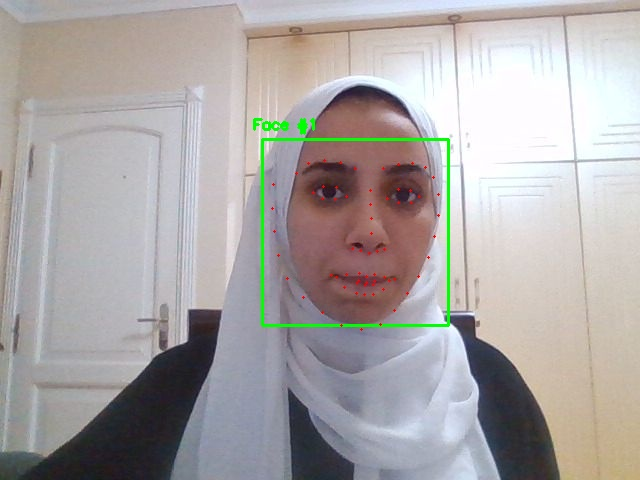

In [19]:
try:
  filename, shape = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [22]:
print(shape)

[[273 184]
 [272 208]
 [274 231]
 [278 255]
 [287 278]
 [303 297]
 [322 312]
 [341 325]
 [361 329]
 [380 324]
 [394 310]
 [407 293]
 [418 276]
 [428 257]
 [434 236]
 [438 215]
 [438 194]
 [296 173]
 [308 163]
 [324 160]
 [340 162]
 [355 168]
 [383 168]
 [398 164]
 [412 163]
 [425 167]
 [433 177]
 [370 190]
 [370 204]
 [371 218]
 [371 233]
 [352 248]
 [360 250]
 [369 253]
 [377 251]
 [384 249]
 [313 192]
 [323 186]
 [336 187]
 [346 196]
 [335 199]
 [322 198]
 [387 198]
 [398 189]
 [410 190]
 [419 196]
 [411 202]
 [398 202]
 [331 275]
 [346 274]
 [359 273]
 [366 276]
 [374 274]
 [384 277]
 [394 279]
 [383 289]
 [373 294]
 [364 294]
 [356 293]
 [344 287]
 [336 277]
 [358 280]
 [366 282]
 [374 281]
 [389 280]
 [373 284]
 [365 285]
 [357 283]]


In [65]:
features = shape.T
print(features)
X_nose = features[0][30]
Y_nose = features[1][30]
ad = np.sum(np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2)) / features.shape[1]
X_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[0] - X_nose) / ad
Y_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[1] - Y_nose) / ad
XY = []

XY.append(X_norm)
XY.append(Y_norm)
XY = np.array(XY)
landmarks= XY.T.flatten().reshape(1,-1)
print(landmarks.shape)

[[273 272 274 278 287 303 322 341 361 380 394 407 418 428 434 438 438 296
  308 324 340 355 383 398 412 425 433 370 370 371 371 352 360 369 377 384
  313 323 336 346 335 322 387 398 410 419 411 398 331 346 359 366 374 384
  394 383 373 364 356 344 336 358 366 374 389 373 365 357]
 [184 208 231 255 278 297 312 325 329 324 310 293 276 257 236 215 194 173
  163 160 162 168 168 164 163 167 177 190 204 218 233 248 250 253 251 249
  192 186 187 196 199 198 198 189 190 196 202 202 275 274 273 276 274 277
  279 289 294 294 293 287 277 280 282 281 280 284 285 283]]
(1, 136)


In [66]:
label_P = p_gb_model.predict(landmarks)
label_P

array([0.01500341])

In [69]:
label_y = y_gb_model.predict(landmarks)
label_y

array([-0.48605028])

In [71]:
label_r = r_gb_model.predict(landmarks)
label_r

array([-7.01693895])

In [67]:
label_P_svm = yaw_model_CG_SVM.predict(landmarks)
print(label_P_svm)

[-0.51204316]


## Trail 02

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


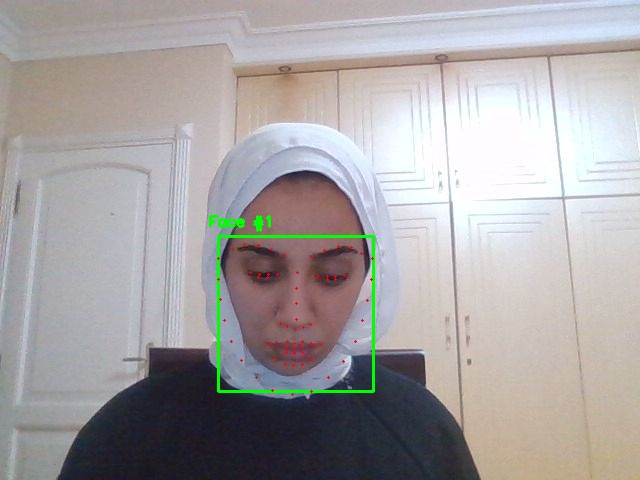

In [72]:
try:
  filename, shape = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [73]:
features = shape.T
print(features)
X_nose = features[0][30]
Y_nose = features[1][30]
ad = np.sum(np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2)) / features.shape[1]
X_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[0] - X_nose) / ad
Y_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[1] - Y_nose) / ad
XY = []

XY.append(X_norm)
XY.append(Y_norm)
XY = np.array(XY)
landmarks= XY.T.flatten().reshape(1,-1)
print(landmarks.shape)

[[218 218 220 224 231 241 256 272 292 311 328 343 355 362 367 371 372 233
  244 258 271 284 311 324 338 351 361 297 296 296 296 280 287 295 303 310
  250 259 268 277 267 258 317 327 335 344 335 327 266 276 287 294 302 311
  320 311 302 293 285 275 271 286 294 301 315 302 294 286]
 [258 279 299 320 341 360 377 390 394 391 377 361 341 320 300 279 258 249
  244 245 249 255 256 250 246 247 253 272 288 303 319 323 326 329 327 324
  272 274 274 274 277 277 276 276 276 275 279 279 343 342 341 343 341 343
  344 358 364 365 364 358 345 347 348 347 346 352 353 352]]
(1, 136)


In [74]:
label_P = p_gb_model.predict(landmarks)
label_P

array([0.6730897])

In [75]:
label_y = y_gb_model.predict(landmarks)
label_y

array([-0.89716576])

In [76]:
label_r = r_gb_model.predict(landmarks)
label_r

array([-0.47798746])

## Trail 03

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


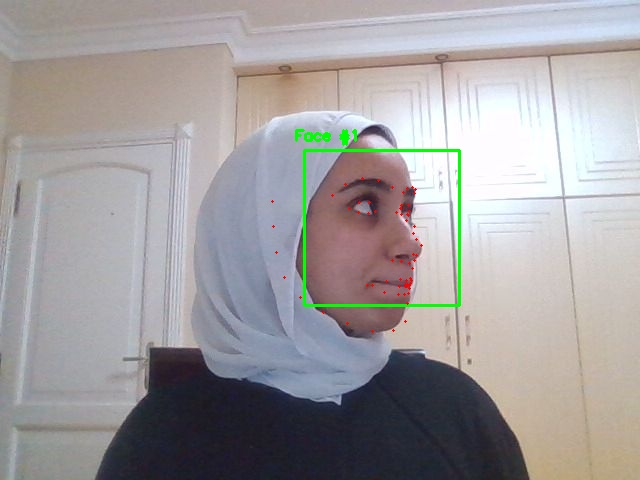

In [80]:
try:
  filename, f = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [81]:
features = f.T
print(features)
X_nose = features[0][30]
Y_nose = features[1][30]
ad = np.sum(np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2)) / features.shape[1]
X_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[0] - X_nose) / ad
Y_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[1] - Y_nose) / ad
XY = []

XY.append(X_norm)
XY.append(Y_norm)
XY = np.array(XY)
landmarks= XY.T.flatten().reshape(1,-1)
print(landmarks.shape)

[[272 273 276 284 300 323 347 372 393 405 407 410 412 413 416 414 408 332
  345 362 378 392 403 407 412 415 414 400 406 413 421 392 401 409 414 416
  349 359 369 375 368 358 396 401 408 409 407 401 367 386 400 406 410 411
  407 409 408 404 398 384 372 399 405 409 405 409 406 399]
 [201 226 252 277 297 312 323 331 330 321 303 283 268 254 239 226 215 195
  184 178 180 187 192 188 187 189 193 208 220 233 245 260 261 263 260 255
  208 202 202 211 213 212 212 205 205 211 214 214 285 281 279 280 278 280
  284 288 293 294 294 292 285 286 286 285 284 284 286 286]]
(1, 136)


In [82]:
label_P = p_gb_model.predict(landmarks)
label_P

array([-1.32443503])

In [83]:
label_y = y_gb_model.predict(landmarks)
label_y

array([-0.90314054])

In [84]:
label_r = r_gb_model.predict(landmarks)
label_r

array([-0.26587993])

## Trail 04

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


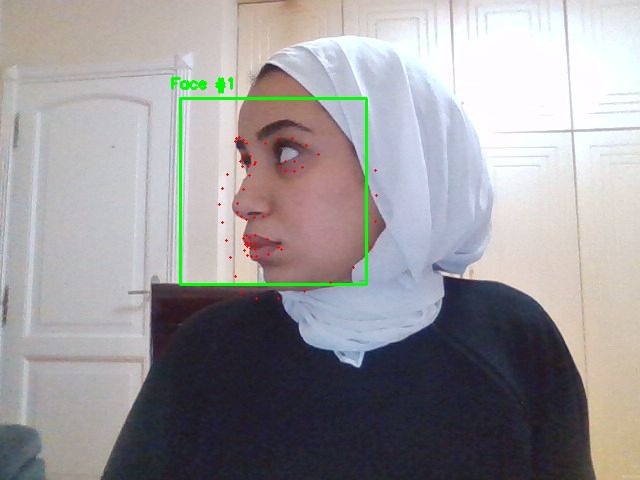

In [96]:
try:
  filename, h = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [101]:
features = h.T
print(features)
X_nose = features[0][30]
Y_nose = features[1][30]
ad = np.sum(np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2)) / features.shape[1]
X_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[0] - X_nose) / ad
Y_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[1] - Y_nose) / ad
XY = []

XY.append(X_norm)
XY.append(Y_norm)
XY = np.array(XY)
landmarks= XY.T.flatten().reshape(1,-1)
print(landmarks.shape)

[[227 222 219 222 226 230 235 241 256 278 304 330 353 370 375 376 375 235
  236 239 243 246 265 277 292 306 318 255 249 243 237 237 241 246 254 263
  240 242 250 254 248 242 280 285 294 302 294 285 245 243 246 249 255 267
  281 268 256 251 247 244 247 246 250 255 278 255 250 247]
 [174 188 204 222 240 257 276 292 298 298 291 282 267 247 221 195 170 141
  138 137 140 143 143 138 138 145 154 162 175 189 203 212 216 219 217 216
  161 155 156 164 166 166 167 161 161 167 171 171 244 238 235 237 235 239
  249 254 256 256 255 250 244 242 243 243 247 249 248 246]]
(1, 136)


In [102]:
label_P = p_gb_model.predict(landmarks)
label_P

array([1.37403407])

In [103]:
label_y = y_gb_model.predict(landmarks)
label_y

array([-0.54317385])

In [104]:
label_r = r_gb_model.predict(landmarks)
label_r

array([-9.96965037])

## Trail 05

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


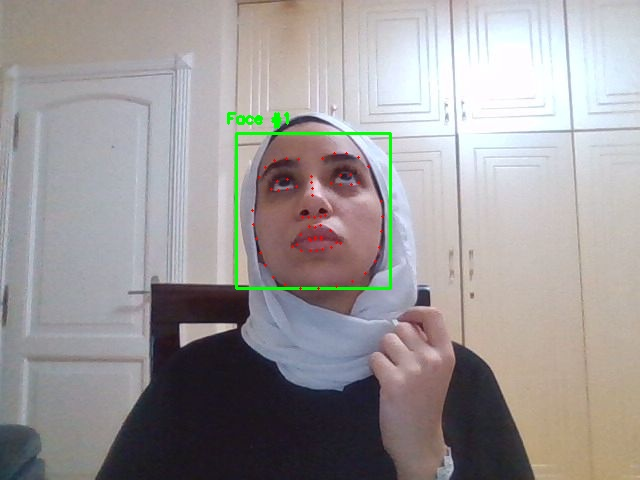

In [105]:
try:
  filename, shape = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [106]:
features = shape.T
print(features)
X_nose = features[0][30]
Y_nose = features[1][30]
ad = np.sum(np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2)) / features.shape[1]
X_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[0] - X_nose) / ad
Y_norm = np.sqrt((features[0] - X_nose)**2  + (features[1] - Y_nose)**2) * (features[1] - Y_nose) / ad
XY = []

XY.append(X_norm)
XY.append(Y_norm)
XY = np.array(XY)
landmarks= XY.T.flatten().reshape(1,-1)
print(landmarks.shape)

[[252 253 256 260 265 273 285 300 318 336 352 365 375 379 381 382 381 259
  265 274 286 298 322 334 346 358 368 311 311 312 312 302 308 314 320 325
  271 277 287 296 287 278 331 340 350 358 351 340 292 300 309 315 320 330
  340 331 322 316 310 301 297 309 315 321 336 321 315 310]
 [210 224 238 252 265 277 284 288 288 286 281 273 261 247 231 216 201 177
  167 160 158 159 158 153 153 157 166 176 182 188 195 217 217 217 216 215
  189 181 179 186 189 190 183 175 174 182 184 184 246 234 226 227 225 230
  243 247 249 250 250 250 244 238 237 237 242 239 239 240]]
(1, 136)


In [107]:
label_P = p_gb_model.predict(landmarks)
label_P

array([1.87345905])

In [108]:
label_y = y_gb_model.predict(landmarks)
label_y

array([-1.03943592])

In [109]:
label_r = r_gb_model.predict(landmarks)
label_r

array([-9.19594895])

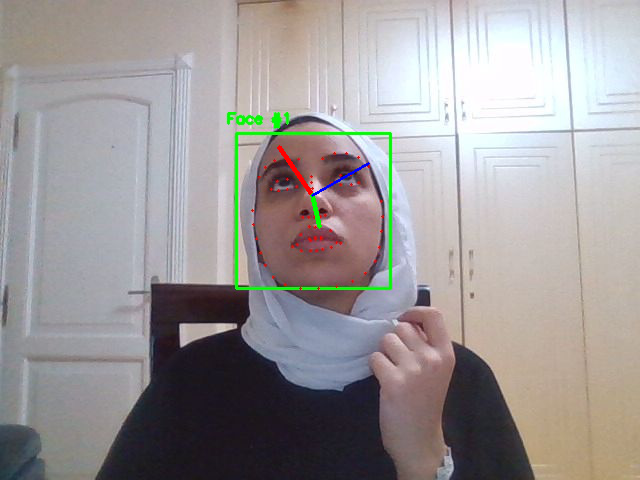

In [117]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 
img = imread("photo.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, width//2)
cv2_imshow(img)

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


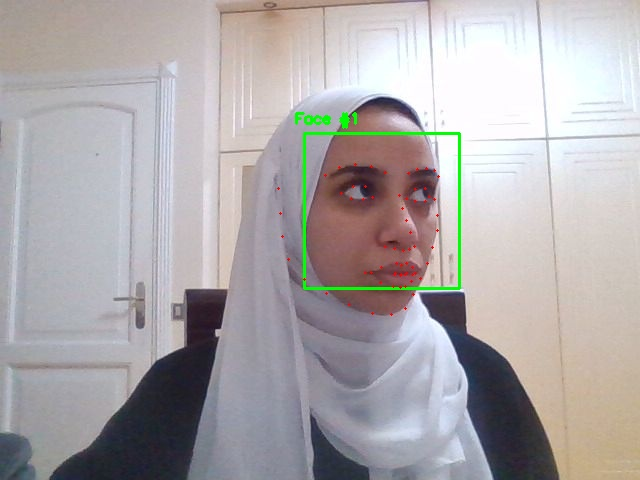

In [15]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Video

In [16]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [17]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print(gray.shape)
    # get face bounding box coordinates using Haar Cascade
    #faces = face_cascade.detectMultiScale(gray)
    # detect faces in the grayscale image
    faces = detector(gray, 1)
    # draw face bounding box on image
    # for (x,y,w,h) in faces:
    #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    # loop over the face detections
    for (i, rect) in enumerate(faces):
      # determine the facial landmarks for the face region, then
      # convert the facial landmark (x, y)-coordinates to a NumPy
      # array
      shape = predictor(gray, rect)
      shape = shape_to_np(shape)
      # convert dlib's rectangle to a OpenCV-style bounding box
      # [i.e., (x, y, w, h)], then draw the face bounding box
      (x, y, w, h) = face_utils.rect_to_bb(rect)
      bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)
      # show the face number
      cv2.putText(bbox_array, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      # loop over the (x, y)-coordinates for the facial landmarks
      # and draw them on the image
      for (x, y) in shape:
         cv2.circle(bbox_array, (x, y), 1, (0, 0, 255), -1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
 # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # detect faces in the grayscale image
  faces = detector(gray, 1)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # loop over the face detections
  for (i, rect) in enumerate(faces):
	  # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
      cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
  # cv2_imshow("Output", img)
  # save image
  cv2.imwrite(filename, img)

  return filename